In [1]:
import numpy as np # Pour faire des maths et gérer des matrices
import pandas as pd # Pour manipuler les données (lire des CSV, créer des tableaux)
import os # Pour interagir avec le système de fichiers de l'ordinateur
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import gc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('./metadata.csv')
df.head()


,Image,Mask
0,water_body_1000_blur.jpg,water_body_1000_blur.jpg
1,water_body_1000_bright.jpg,water_body_1000_bright.jpg
2,water_body_1000_flip.jpg,water_body_1000_flip.jpg
3,water_body_1000_orig.jpg,water_body_1000_orig.jpg
4,water_body_1000_rot40.jpg,water_body_1000_rot40.jpg


In [4]:
df.columns


Index(['Image', 'Mask'], dtype='object')

In [5]:
image_dir = './Images'
mask_dir = './Masks'

# On choisit un fichier spécifique (ID) qui existe dans les deux dossiers
base_filename = 'water_body_186_orig'

#  On construit les chemins d'accès.
# L'image est souvent en JPG (photo) et le masque en PNG (pour garder les valeurs exactes des pixels)
image_path = os.path.join(image_dir, base_filename + '.jpg')
mask_path = os.path.join(mask_dir, base_filename + '.jpg')

# C'est ici qu'on transforme les fichiers en tableaux de nombres (matrices) pour que le modèle puisse les lire.
# L'image est chargée normalement (en couleur BGR par défaut avec OpenCV)
img = cv2.imread(image_path)
# Le masque est chargé IMPÉRATIVEMENT en niveaux de gris (Grayscale)
# Car chaque pixel représente une classe (ex: 0=fond, 1=chat), pas une couleur visuelle.
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

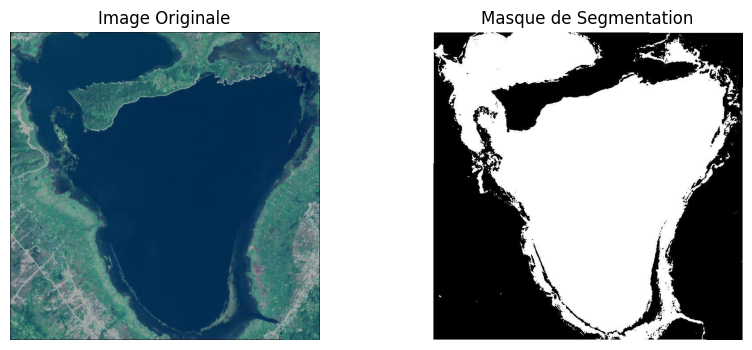

In [6]:
# Verification Est-ce que l'image existe ?
if img is not None:
    
    #   mettre les 2 images côte à côte
    plt.figure(figsize=(10, 4))
    
    # --- IMAGE DE GAUCHE (La Photo) ---
    plt.subplot(1, 2, 1) # 1 ligne, 2 colonnes, position 1
    
    # Conversion CRUCIALE : OpenCV est en BGR, on doit convertir en RGB pour l'affichage correct
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Image Originale")
    plt.axis('off') # On cache les axes chiffrés pour faire plus propre
    
    # --- IMAGE DE DROITE (Le Masque) ---
    plt.subplot(1, 2, 2) # 1 ligne, 2 colonnes, position 2
    
    # On affiche le masque en niveaux de gris (noir et blanc) pour bien voir les classes
    plt.imshow(mask, cmap='gray')
    plt.title("Masque de Segmentation")
    plt.axis('off')
    
    #  On affiche le résultat final à l'écran
    plt.show()

else:
    # Si le chargement a échoué, on prévient l'utilisateur
    print("Erreur : L'image est vide. Vérifie ton chemin d'accès (path).")

In [7]:
IMG_PATH = './images'
MASK_PATH = './masks'
IMG_SIZE = 128 # Taille cible pour l'entrée du réseau (plus c'est petit, plus c'est rapide)

# On liste tout ce qu'il y a dans les dossiers
image_files = sorted(os.listdir(IMG_PATH))
mask_files = sorted(os.listdir(MASK_PATH))

# On ne garde que le nom sans l'extension 
image_basenames = set([f.split('.')[0] for f in image_files])
mask_basenames = set([f.split('.')[0] for f in mask_files])

# L'opération '&' (intersection) ne garde que les noms présents dans les DEUX dossiers
# Cela évite les erreurs si une image n'a pas de masque correspondant
common_basenames = sorted(list(image_basenames & mask_basenames))

# ---  CHARGEMENT ET PRETRAITEMENT ---
X, Y = [], [] # Listes vides pour stocker les données finales

for name in common_basenames:
    # Chargement
    img = cv2.imread(f"{IMG_PATH}/{name}.jpg")
    mask = cv2.imread(f"{MASK_PATH}/{name}.jpg", 0) # 0 force le mode Noir & Blanc (1 canal)

    # Sécurité : Si le fichier est corrompu ou illisible, on l'ignore
    if img is not None and mask is not None:
        
        # Redimensionnement pour uniformiser la taille
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Normalisation : On passe de [0, 255] à [0, 1]
        # Cela aide le réseau de neurones à apprendre plus vite (convergence)
        img = img / 255.0
        mask = mask / 255.0

        # Ajout aux listes principales
        X.append(img)
        Y.append(mask)

In [8]:
# Conversion des Images (X)
# On transforme la liste en un tableau Numpy (Matrix).
# Comme les images sont en couleur, la forme sera automatiquement (N, 128, 128, 3)
X = np.array(X, dtype=np.float32)
# Nettoyage final
gc.collect()

# 2. Conversion et Remodelage des Masques (Y)
# D'abord on convertit en Numpy array.
# Ensuite, on utilise .reshape() pour ajouter la dimension du canal "Channel".
# -1 : "Prends toutes les images disponibles" (Batch size automatique)
# 1  : "Il n'y a qu'un seul canal de couleur" (Niveaux de gris)
# Forme finale : (N, 128, 128, 1)
Y = np.array(Y, dtype=np.float32).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Nettoyage final
gc.collect()


print(f"Forme de X (Images) : {X.shape}") 
print(f"Forme de Y (Masques) : {Y.shape}") 

Forme de X (Images) : (14205, 128, 128, 3)
Forme de Y (Masques) : (14205, 128, 128, 1)


In [9]:
# Découpage des données
# X_train, Y_train : Données pour apprendre (Training set)
# X_test, Y_test   : Données pour valider/tester (Validation set)
X_train, X_test, Y_train, Y_test = train_test_split(
    X,              # Les images (features)
    Y,      # Les masques (labels)
    test_size=0.2,  # On garde 20% des images pour le test (donc 80% pour l'entraînement)
    random_state=42 # Assure que le mélange est reproductible (toujours le même découpage)
)

# Petit contrôle pour voir combien d'images on a dans chaque groupe
print(f"Images d'entraînement : {X_train.shape[0]}")
print(f"Images de test : {X_test.shape[0]}")

Images d'entraînement : 11364
Images de test : 2841


In [10]:
#  LA MÉTRIQUE "IoU" (Le Juge Impartial)
def iou_metric(y_true, y_pred):
    # Pourquoi cette fonction ?
    # L'accuracy classique (précision) est menteuse en segmentation (surtout s'il y a beaucoup de fond noir).
    # L'IoU mesure vraiment si la forme dessinée se superpose bien à la vraie forme.

    # Si > 0.5 alors c'est un pixel blanc (1), sinon c'est noir (0).
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    # Intersection : On compte les pixels où l'IA et la Vérité sont d'accord (Blanc sur Blanc).
    intersection = tf.reduce_sum(y_true * y_pred)
    
    # Union : C'est la surface totale occupée par les deux masques réunis.
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    # Le calcul final : Intersection divisée par Union.
    # Le "+ 1e-7" est une sécurité mathématique pour éviter une division par zéro (crash) si l'image est vide.
    return intersection / (union + 1e-7)

#  L'ARCHITECTURE U-NET (Le Cerveau en forme de U)

def build_unet(input_shape=(128, 128, 3)):
    
    # On définit la porte d'entrée du modèle (taille de l'image)
    inputs = Input(input_shape)

    # --- PARTIE 1 : LA DESCENTE (L'Encodeur) ---
    # Le but : Comprendre "QUOI" est sur l'image (contexte).
    # On réduit la taille de l'image petit à petit, mais on augmente le nombre de filtres (caractéristiques).

    # Étage 1 : Haute résolution
    # Conv2D : L'œil de l'IA scanne l'image pour trouver des traits simples.
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1) # On "éteint" 10% des neurones au hasard pour forcer les autres à mieux travailler.
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1) # Zoom arrière : On divise la taille par 2. On garde c1 en mémoire !

    # Étage 2 : Résolution Moyenne
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2) # Zoom arrière encore. On garde c2 en mémoire !

    # Étage 3 : Basse Résolution
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3) # On augmente un peu le Dropout car on a plus de filtres.
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3) # Zoom arrière. On garde c3 en mémoire !

    # --- PARTIE 2 : LE FOND DU GOUFFRE (Bottleneck) ---
    # C'est le point le plus compressé. L'image est toute petite (pixels), mais très riche en infos abstraites.
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    # --- PARTIE 3 : LA REMONTÉE (Le Décodeur) ---
    # Le but : Savoir "OÙ" est l'objet et reconstruire le masque précis.
    # C'est ici que la magie du U-Net opère grâce aux "Ponts" (concatenate).

    # Remontée 1
    u5 = UpSampling2D((2, 2))(c4) # Zoom avant : On agrandit l'image.
    # LE PONT (Skip Connection) : On colle l'image floue actuelle (u5) avec l'image nette de l'étape 3 (c3).
    # Cela permet de retrouver les détails perdus lors de la descente.
    u5 = concatenate([u5, c3]) 
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Remontée 2
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2]) # On récupère les détails de l'étage 2
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Remontée 3
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1]) # On récupère les détails de l'étage 1 (très haute définition)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # --- SORTIE ---
    # On veut une seule image finale en noir et blanc (1 canal).
    # 'sigmoid' force chaque pixel à être une probabilité entre 0 (Noir) et 1 (Blanc).
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    # On assemble le tout dans un modèle Keras
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


#  COMPILATION DU MODÈLE
# On construit l'architecture
model = build_unet()

# On donne les règles du jeu au modèle :
# - optimizer='adam' : C'est le coach qui ajuste les neurones pour réduire l'erreur.
# - loss='binary_crossentropy' : La méthode pour calculer l'erreur (Pixel Noir vs Pixel Blanc).
# - metrics : On lui demande d'afficher l'Accuracy (classique) ET notre IoU (la vraie note).
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric])

# Affiche le résumé technique (nombre de paramètres, forme des couches...)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128, 128, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 16)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 32)        │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64, 64, 32)        │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 32, 32, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 16, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 16, 16, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 16, 16, 128)       │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ---  CONFIGURATION DE L'ARBITRE (Early Stopping) ---
# Cet outil surveille l'entraînement en temps réel.
early_stopper = EarlyStopping(
    monitor='val_loss', # Ce qu'on surveille : l'erreur sur les données de test (Validation Loss)
    patience=5,         # La tolérance : "Si l'erreur ne baisse pas pendant 5 tours de suite, ARRÊTE TOUT."
    verbose=1,          # Affiche un message quand il décide d'arrêter.
    restore_best_weights=True # TRES IMPORTANT : À la fin, il remet le modèle dans son meilleur état (il annule les 5 derniers tours inutiles).
)

# ---  LE FILET DE SÉCURITÉ (Model Checkpoint) ---
# Cet outil sauvegarde le modèle sur ton disque dur à chaque fois qu'il bat son record.
checkpointer = ModelCheckpoint(
    'meilleur_modele_unet.keras', # Le nom du fichier de sauvegarde
    monitor='val_loss',        # On surveille l'erreur de validation
    save_best_only=True,       # On ne sauvegarde QUE si le modèle est meilleur que le précédent
    verbose=1
)

# --- 3. LANCEMENT DE L'ENTRAÎNEMENT ---
# On met epochs=50 , mais grâce au "early_stopper", 
history = model.fit(
    X_train, Y_train,
    validation_split=0.1, # On garde 10% des données d'entrainement pour la vérification en direct
    batch_size=16,        # On envoie les images par paquets de 16
    epochs=100,            # C'est un plafond maximum, pas une obligation !
    callbacks=[early_stopper, checkpointer] # On active nos deux assistants
)

Epoch 1/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.6005 - iou_metric: 0.2621 - loss: 0.5319
Epoch 1: val_loss improved from None to 0.44082, saving model to meilleur_modele_unet.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 528s 812ms/step - accuracy: 0.6396 - iou_metric: 0.4045 - loss: 0.4718 - val_accuracy: 0.6662 - val_iou_metric: 0.5733 - val_loss: 0.4408
Epoch 2/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.6875 - iou_metric: 0.5729 - loss: 0.3818
Epoch 2: val_loss improved from 0.44082 to 0.37171, saving model to meilleur_modele_unet.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 480s 750ms/step - accuracy: 0.6955 - iou_metric: 0.5904 - loss: 0.3644 - val_accuracy: 0.6919 - val_iou_metric: 0.6144 - val_loss: 0.3717
Epoch 3/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.7087 - iou_metric: 0.6276 - loss: 0.3355
Epoch 3: val_loss improved from 0.37171 to 0.31797, saving model to meilleur_modele_unet.keras
640/640 ━━━━━━━━━━━━━━━━━━━━ 484s 756ms/step - accurac

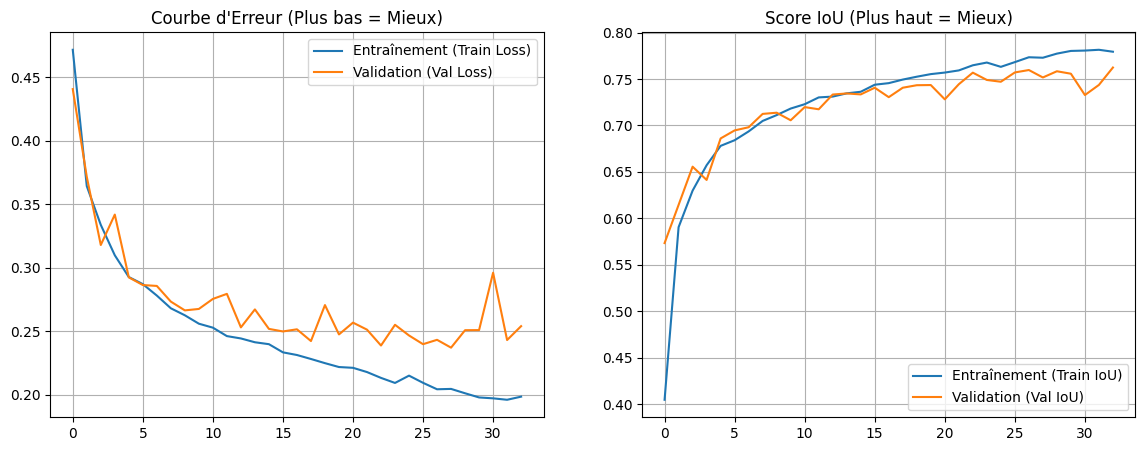

In [12]:
#  On récupère les données brutes de l'entraînement
# 'history.history' est un dictionnaire qui contient toutes les notes tour par tour.
loss = history.history['loss']            # Erreur sur les données d'entraînement
val_loss = history.history['val_loss']    # Erreur sur les données de validation (Test)
iou = history.history['iou_metric']       # Score IoU sur l'entraînement
val_iou = history.history['val_iou_metric'] # Score IoU sur la validation

# On crée l'axe des X (le nombre de tours effectués)
epochs_range = range(len(loss))

#  On prépare le dessin (Une figure large avec 2 graphiques)
plt.figure(figsize=(14, 5))

# --- GRAPHIQUE DE GAUCHE : L'ERREUR (LOSS) ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Entraînement (Train Loss)')
plt.plot(epochs_range, val_loss, label='Validation (Val Loss)')
plt.title('Courbe d\'Erreur (Plus bas = Mieux)')
plt.legend(loc='upper right') # Affiche la légende
plt.grid(True) # Ajoute une grille pour faciliter la lecture

# --- GRAPHIQUE DE DROITE : LA PERFORMANCE (IoU) ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, iou, label='Entraînement (Train IoU)')
plt.plot(epochs_range, val_iou, label='Validation (Val IoU)')
plt.title('Score IoU (Plus haut = Mieux)')
plt.legend(loc='lower right')
plt.grid(True)

# 3. Affichage final
plt.show()

Génération des prédictions en cours...
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 387ms/step
--- RÉSULTATS DU TEST ---
Perte (Loss)        : 0.2322
Précision (Accuracy): 0.7432
Score IoU (Métrique): 0.7468


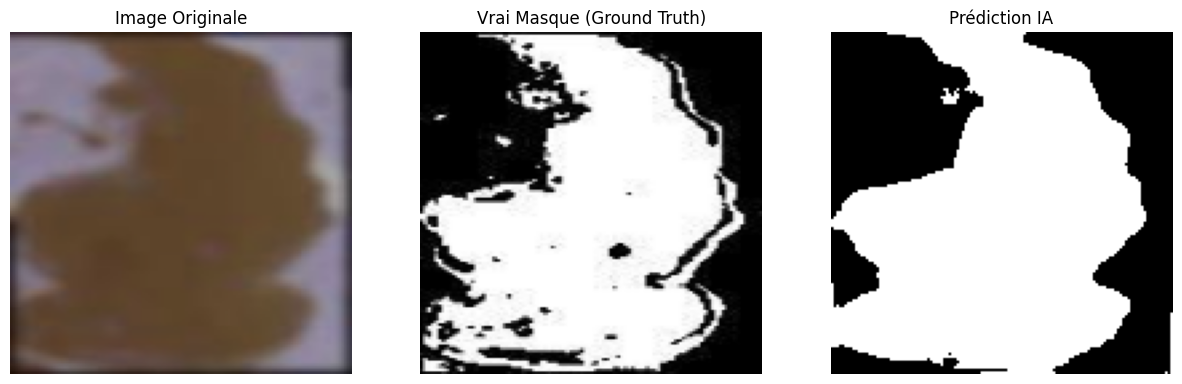

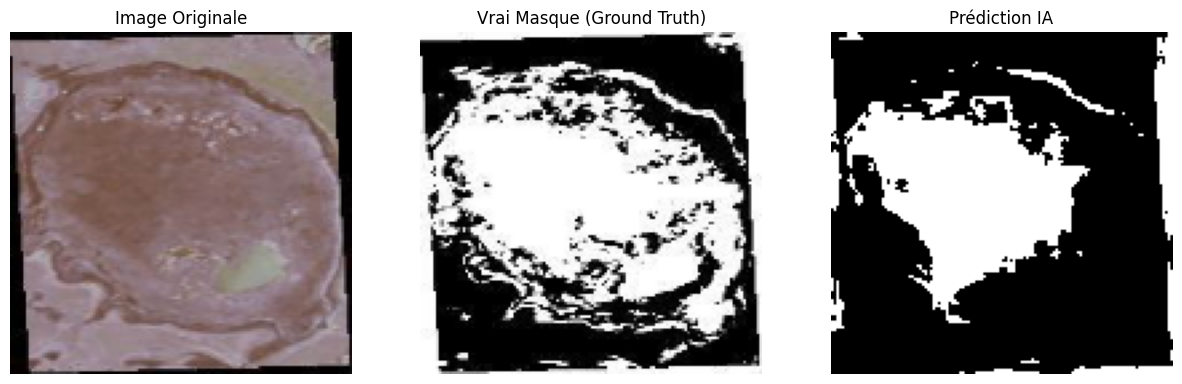

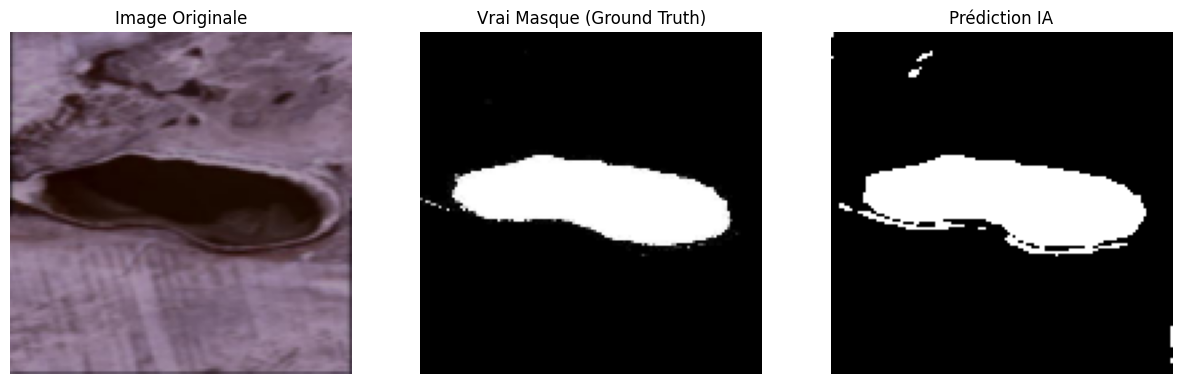

In [13]:
#  GÉNÉRATION DES PRÉDICTIONS
# On demande au modèle de prédire les masques pour TOUTES les images de test.
print("Génération des prédictions en cours...")
preds_test = model.predict(X_test, verbose=1)

# Le modèle sort des probabilités, On tranche : Si > 0.5 c'est blanc (1), sinon c'est noir (0).
preds_test_t = (preds_test > 0.5).astype(np.uint8)


#  ÉVALUATION CHIFFRÉE (Les Notes)

# On compare mathématiquement les prédictions avec les vrais masques (Y_test)
# model.evaluate retourne une liste : [Loss, Accuracy, IoU_Metric]
score = model.evaluate(X_test, Y_test, verbose=0)

print("--- RÉSULTATS DU TEST ---")
print(f"Perte (Loss)        : {score[0]:.4f}") # Doit être bas
print(f"Précision (Accuracy): {score[1]:.4f}") # Souvent trompeur
print(f"Score IoU (Métrique): {score[2]:.4f}") # LA vraie note importante !


# 3. VISUALISATION (La Preuve par l'Image)
# On va piocher 3 images au hasard dans le test pour voir le résultat.

for i in range(3):
    # On choisit un index au hasard
    idx = random.randint(0, len(X_test) - 1)
    
    plt.figure(figsize=(15, 5))
    
    # --- IMAGE ORIGINALE ---
    plt.subplot(1, 3, 1)
    # X_test est en RGB (couleur)
    plt.imshow(X_test[idx]) 
    plt.title("Image Originale")
    plt.axis('off')
    
    # --- VRAI MASQUE (La Correction) ---
    plt.subplot(1, 3, 2)
    # .squeeze() sert à enlever la dimension "1" inutile (128, 128, 1) -> (128, 128)
    plt.imshow(Y_test[idx].squeeze(), cmap='gray')
    plt.title("Vrai Masque (Ground Truth)")
    plt.axis('off')
    
    # --- PRÉDICTION (Ce que l'IA a vu) ---
    plt.subplot(1, 3, 3)
    plt.imshow(preds_test_t[idx].squeeze(), cmap='gray')
    plt.title(f"Prédiction IA")
    plt.axis('off')
    
    plt.show()
